In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf
#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [2]:
#Import simulated XRD
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
print(theor.shape)
theor = theor.iloc[1:,]
theor_arr = theor.values
print(theor_arr.shape)

# Normalize data for training
ntheor = normdata(theor_arr)
print(ntheor.shape)

#exp = pd.read_csv('Datasets/exp.csv', index_col=0)
#exp_arr = exp.values
#print(exp_arr.shape)

(2402, 1468)
(2401, 1468)
(2401, 734)


In [3]:
#Import dimensionalities
label_theo = pd.read_csv('Datasets/label_theo_dataaug.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

# Load experimental class labels
#label_exp= pd.read_csv('Datasets/label_theo.csv', index_col=0).values
#label_exp = label_exp.reshape([len(label_exp),])

space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

print(len(label_theo))
print(ntheor.shape)

1468
(2401, 734)


In [4]:
#augdata(data,num,par1,minn,maxn)
# Specify how many data points we augmented
th_num = 800

# Define 2theta range for data augmentation
exp_min = 0
exp_max = 2000
theor_min = 0
theor_max = theor_min+exp_max-exp_min

# Perform data augmentation
augd, pard, crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max) 

# Enconde theoretical labels
label_t = np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i] = space_group_enc.index(pard[i])

print(augd.shape)
print(crop_augd.shape)
print(label_t.shape)

(2401, 800)
(2000, 800)
(800,)


In [50]:
#prepare X et Y
X_th = np.transpose(crop_augd)
#X_th = X_th.reshape(734, 2401, 1)
X_th = X_th.reshape(th_num, exp_max-exp_min, 1)
Y_th = label_t

X_th = X_th.astype(np.float32)
Y_th = Y_th.astype(np.float32)

# Shuffle dataset
indexes = np.arange(th_num)
np.random.shuffle(indexes)
X_th = X_th[indexes]
Y_th = Y_th[indexes]

print(X_th.shape)
print(Y_th.shape)

(800, 2000, 1)
(800,)


In [51]:
# Introduction de set de test à partir de la base de données
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_valid, Y_th_train, Y_th_valid = train_test_split(X_th, Y_th, test_size=0.33)

print("X_th_train", X_th_train.shape)
print("X_th_valid", X_th_valid.shape)

print("Y_th_train", Y_th_train.shape)
print("Y_th_valid", Y_th_valid.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_th, Y_th))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_th_valid, Y_th_valid))

print(train_dataset)
print(valid_dataset)

X_th_train (536, 2000, 1)
X_th_valid (264, 2000, 1)
Y_th_train (536,)
Y_th_valid (264,)
<TensorSliceDataset shapes: ((2000, 1), ()), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((2000, 1), ()), types: (tf.float32, tf.float32)>


In [52]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for X_th_batch, Y_th_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(X_th_batch.shape, Y_th_batch.shape)
    break

(32, 2000, 1) (32,)


In [53]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=20, strides=1, padding='same', activation='relu', name="conv1")
        #self.pool1 = tf.compat.v1.layers.MaxPooling1D(pool_size=3, strides=3, padding='same', name="pool1")
        self.conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=15, strides=1, padding='same', activation='relu', name="conv2")
        #self.pool2 = tf.compat.v1.layers.MaxPooling1D(pool_size=2, strides=3, padding='same', name="pool2")
        self.conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, padding='same', activation='relu', name="conv3")
        #self.pool3 = tf.compat.v1.layers.MaxPooling1D(pool_size=1, strides=2, padding='same', name="pool3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(1024, activation='relu', name="d1")
        self.d2 = tf.keras.layers.Dense(128, activation='relu', name="d2")
        self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")

    def call(self, X_th):
        conv1 = self.conv1(X_th)
        #pool1 = self.pool1(conv1)
        conv2 = self.conv2(conv1)
        #pool2 = self.pool2(conv2)
        conv3 = self.conv3(conv2)
        #pool3 = self.pool1(conv3)
        #print(conv3)
        flatten = self.flatten(conv3)
        #print(flatten)
        d1 = self.d1(flatten)
        d2 = self.d2(d1)
        #print(d1)
        output = self.out(d2)
        return output

model = ConvModel()
model.predict(X_exp[:,:,:])

array([[0.24961264, 0.2509645 , 0.2506044 , 0.24881843],
       [0.2509072 , 0.24925978, 0.2511122 , 0.24872077],
       [0.2498339 , 0.2504009 , 0.25135842, 0.24840666],
       [0.25265196, 0.2473331 , 0.25081944, 0.24919556],
       [0.25041705, 0.24998897, 0.25035793, 0.24923605],
       [0.25101244, 0.24891783, 0.2513055 , 0.2487642 ],
       [0.25086138, 0.249334  , 0.25056225, 0.2492424 ],
       [0.25044534, 0.2506885 , 0.25064728, 0.24821888],
       [0.25045547, 0.24961449, 0.25031734, 0.2496127 ],
       [0.25206175, 0.2482136 , 0.25172606, 0.24799861],
       [0.25125718, 0.24936381, 0.24986388, 0.24951509],
       [0.25032312, 0.24853022, 0.25230944, 0.24883714]], dtype=float32)

In [54]:
#Define loss, optimizer, accuracy for the model to compile
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [55]:
# Definition de la fonction qui va entrainer le modele
# On utilise un graphe @
@tf.function
def train_step(X_th, Y_th):
    # Calcul du gradient
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(X_th)
        # Get the error/loss on these predictions
        loss = loss_object(Y_th, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(Y_th, predictions)

In [56]:
# Methode de validation en mode graphe
@tf.function
def valid_step(X_th, Y_th):
    predictions = model(X_th)
    t_loss = loss_object(Y_th, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(Y_th, predictions)

In [57]:
#Iteration du modele
epoch = 20
batch_size = 32
b = 0 #Compter les batchs
for epoch in range(epoch):
    # Training set
    for X_th_batch, Y_th_batch in train_dataset.batch(batch_size): #Iteration dans la dataset
        train_step(X_th_batch, Y_th_batch) #On lance un entrainement
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(Y_th), train_loss.result(), 
            train_accuracy.result()*100
        ), end="") #Informations de l'entrainement
        b += batch_size
    # Validation set
    for X_th_batch, Y_th_batch in valid_dataset.batch(batch_size):
        valid_step(X_th_batch, Y_th_batch) #Mesure precision sur chacun des batch

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    #A la fin de chaque epoch on vide
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 768/800, Loss: 0.9856610894203186, Accuracy: 66.015625854980474
Epoch 1, Valid Loss: 0.6304437518119812, Valid Accuracy: 78.40909576416016
 Batch 1568/800, Loss: 0.5812447667121887, Accuracy: 79.87592175292969
Epoch 2, Valid Loss: 0.37490540742874146, Valid Accuracy: 85.2272720336914
 Batch 2368/800, Loss: 0.3162996768951416, Accuracy: 88.751671752929692
Epoch 3, Valid Loss: 0.12170782685279846, Valid Accuracy: 95.07575988769531
 Batch 3168/800, Loss: 0.17402862012386322, Accuracy: 93.75578247070316
Epoch 4, Valid Loss: 0.05209125578403473, Valid Accuracy: 98.86363983154297
 Batch 3968/800, Loss: 0.09394215792417526, Accuracy: 96.87595593261719
Epoch 5, Valid Loss: 0.11270209401845932, Valid Accuracy: 96.59090423583984
 Batch 4768/800, Loss: 0.07632657885551453, Accuracy: 98.01667175292969
Epoch 6, Valid Loss: 0.03315172344446182, Valid Accuracy: 98.86363983154297
 Batch 5568/800, Loss: 0.0859200730919838, Accuracy: 98.091667175292969
Epoch 7, Valid Loss: 0.07057318836450577, Va

In [64]:
res = model.predict(X_th[:,:,:])
print(res.shape)
for i in range(0, 10):
    print(res[i], Y_th[i])

(800, 4)
[7.3570739e-08 9.9999988e-01 1.6435768e-09 5.0384175e-15] 1.0
[1.0782792e-05 9.9987793e-01 1.1101042e-04 3.1408106e-07] 1.0
[5.445273e-30 7.272304e-16 1.000000e+00 7.333721e-19] 2.0
[3.5040991e-14 1.0000000e+00 3.9825525e-09 1.5102907e-11] 1.0
[2.6809794e-17 2.0537932e-15 1.0000000e+00 4.7677633e-13] 2.0
[3.2774455e-08 9.9999940e-01 6.0146476e-07 1.3088530e-11] 1.0
[9.9999833e-01 1.5318375e-06 1.6851715e-07 2.1127462e-10] 0.0
[7.1897519e-14 6.1292083e-09 6.2806080e-08 9.9999988e-01] 3.0
[3.1224624e-12 1.0000000e+00 3.2373582e-10 6.9415784e-10] 1.0
[4.0240309e-23 7.0247189e-17 1.0000000e+00 1.1582719e-18] 2.0


(4249, 24)


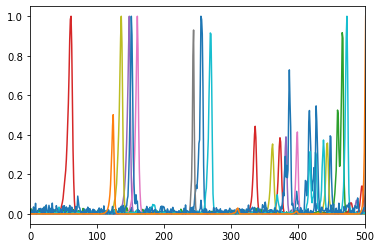

(4249, 12)


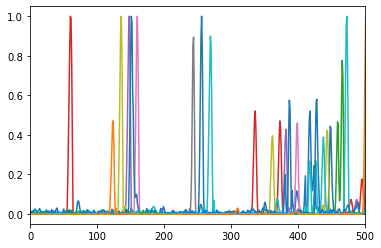

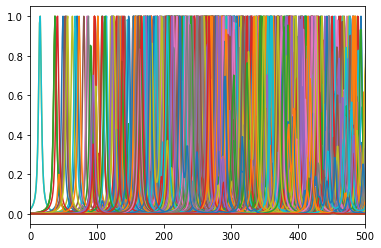

(2000, 12)


In [15]:
#Load experimental data as dataframe
exp = pd.read_csv('Datasets/exp2_raw.csv', index_col=0)
exp_arr = exp.values
#exp_arr = exp_arr.astype(np.float32)
print(exp_arr.shape)

#Normalisation
nexp = normdata(exp_arr)
plt.plot(nexp)
plt.xlim(0,500)
plt.show()
print(nexp.shape)

# Process data experimental
# Define spectral range for data augmentation

#window size for experimental data extraction
window = 10
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing(nexp, exp_min, exp_max, window))

plt.plot(post_exp)
plt.xlim(0,500)
plt.show()

plt.xlim(0,500)
plt.plot(ntheor)
plt.show()

print(post_exp.shape)

# Augment data, this may take a bit
#augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)
# Input the num of experimetal data points       
exp_num = 12
#prepare arrays
X_exp = np.transpose(post_exp)
X_exp = X_exp.reshape(exp_num, exp_max-exp_min, 1)

X_exp = X_exp.astype(np.float32)

In [67]:
model.predict(X_exp[:,:,:])

array([[1.06378055e-14, 1.00000000e+00, 3.15584989e-11, 4.34026187e-13],
       [5.84539433e-04, 2.94736415e-01, 7.04629779e-01, 4.92245890e-05],
       [4.34279063e-05, 9.99956608e-01, 1.22764689e-12, 2.18138428e-14],
       [2.99648661e-09, 9.99285519e-01, 7.14529364e-04, 1.23493138e-09],
       [8.18416302e-04, 1.32709937e-02, 9.85910535e-01, 3.50668721e-08],
       [4.53868019e-08, 4.42249933e-04, 3.09518993e-01, 6.90038681e-01],
       [6.89545923e-05, 9.97133970e-01, 2.79705925e-03, 2.09207207e-09],
       [9.35645381e-11, 4.89239573e-01, 5.10760427e-01, 4.06197600e-08],
       [7.72728759e-04, 1.15065927e-06, 9.99226093e-01, 5.91058180e-09],
       [1.16843163e-04, 5.88945925e-01, 4.10937279e-01, 1.16249883e-11],
       [2.68831067e-02, 1.62774429e-01, 8.10342431e-01, 3.14953952e-09],
       [5.03878346e-06, 6.05060719e-04, 2.22983733e-02, 9.77091491e-01]],
      dtype=float32)